# Etivity 4: Train Naive Bayes Classifier

In this Etivity 4, I will use the seeds data set. More information can be found here: http://archive.ics.uci.edu/ml/datasets/seeds.
All columns in this data set are numerical (area of seeds, perimeter of seed, compactness of seed, length of kernel, width of kernel, asymmetry coefficient of seeds, length of kernel groove and type/ varieties). Even though the column is numerical, it looks like a categorical (ordinal) attribute. Each example is a wheat type with either 1 (Kama), 2 (Rosa), and 3 (Canadian).

I will train a Naive Bayes model to predict the type. 

The type column is the dependent variable or target for classification, while all other columns are the predictors. I will use the common convention to refer to the predictors as X and to the target as y.

In [34]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

In [17]:
df = pd.read_csv(r"/Users/steffipoliwoda/Desktop/seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [18]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

I will check for missing values and outliers.

In [19]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. I will check the boxplots for outliers. 

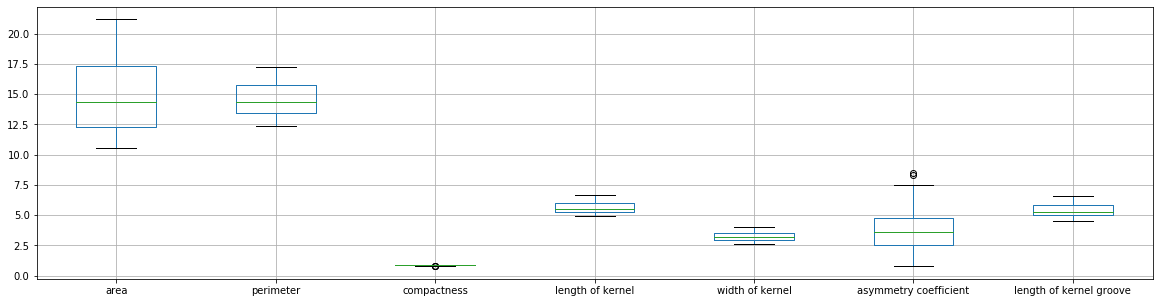

In [20]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

The column asymmetry coefficient has outliers. We will apply log transformation followed by RobustScaler to asymmetry coefficient. To all other predictor columns we will apply StandardScaler.

## Data Preparation

First, I will transform the type column to binary.

In [21]:
mapper = {1: 1, 2 : 0, 3: 0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

I need to prepare two lists of column names. The list names_outliers contains the names of the column to which I will apply log transformation followed by RobustScaler. The list names_no_outliers contains the names of all other predictor columns to which I will apply StandardScaler.

In [22]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [23]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [24]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [25]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [38]:
y = df['type']
X = df.drop('type', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (157, 7)
X_test:  (53, 7)
y_train:  (157,)
y_test:  (53,)


In [39]:
model = GaussianNB()
model.fit (X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [40]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [28]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0])

In [29]:
accuracy = accuracy_score(y_test, y_pred)*100
accuracy

84.90566037735849

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        39
           1       0.62      0.36      0.45        14

    accuracy                           0.77        53
   macro avg       0.71      0.64      0.66        53
weighted avg       0.75      0.77      0.75        53

